# Mie Random Deviates

** Scott Prahl**

** 26 Aug 2017, Version 2**

The problem is to generate random scattering angles which match a given Mie scattering profile.  

This is difficult when the size parameter gets large because nearly all the light is scattered directly forward.  

This notebook is an attempt to solve the scattering problem.

In [1]:
# execute this cell first
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt

# if miepython is missing, do `pip install miepython`
import miepython as mp

#from scipy import stats

## Random Deviates from a PDF

One method of generating a random number $\xi$ with a specified distribution $p(\xi)$ is to create a random event for the variable $\xi$ such that the random event falls with frequency $p(x)dx$ in the interval $(\xi,\xi+d\xi)$.  This method requires the normalization of the probability density function (PDF) over the interval $(a,b)$
$$
\int_a^b p(\xi)d\xi = 1
$$ 
This is done by choosing a random number $R$ uniformly distributed in the interval $[0,1]$ and requiring
$$ 
R=\int_a^\xi p(\xi')d\xi' 
$$ 
Note that $R(\xi)$ represents the cumulative distribution function for $p(\xi')$.

## Azimuthal Angles
A normalized phase function describes the probability density function
for the azimuthal and longitudinal angles for a photon when it is
scattered.  If the phase function has no azimuthal dependence, then the
azimuthal angle $\phi$ is uniformly distributed between 0 and $2\pi$,
and may be generated by multiplying a pseudo-random number $R$
uniformly distributed over the interval [0,1] by $2\pi$
$$
\phi = 2\pi R
$$ 

## Uniformly distributed longitudinal angles
The probability density function for the longitudinal angle
$\theta$ between the current photon direction and the scattered photon
direction is found by integrating the phase function over all azimuthal
angles $p(\cos\theta)$.  For example, the probability density function
for an isotropic distribution is
$$ 
p(\cos\theta)={1\over2}
$$ 
Substituting Equation (A1.9) into Equation (A1.2) yields the
following generating function for cosine of the longitudinal angle
$\theta$
$$
\cos\theta=2R-1
$$

## Random Deviates for Henyey Greenstein

The probability density function corresponding to the Henyey-Greenstein phase function is
$$ 
p(\cos\theta)={1\over2}{1-g_\mathrm{HG}^2\over (1+g_\mathrm{HG}^2-2g_\mathrm{HG}\cos\theta)^{3/2}}
$$ 
The generating function for this distribution obtained the equation above is
$$
\cos\theta = {1\over 2g_\mathrm{HG}}\left\lbrace 
1+g_\mathrm{HG}^2-\left[{1-g_\mathrm{HG}^2\over1-g_\mathrm{HG}+2g_\mathrm{HG} R}\right]
\right\rbrace
$$

This equation should not be used for isotropic scattering --- because of division by zero --- use the equation above.

## Cumulative Distribution Function for Mie scattering

Unfortunately, we cannot do the integral and solve for the angle analytically for the Mie scattering case.  We will need to do it numerically.

We ignore polarization effects and are just considering total scattering of the electric field.  Moreover, we assume that the scattering function $S(\theta,\phi)$ is independent of azimuthal angle $\phi$.  In that case the cumulative distribution function (CDF) is 
$$
\mathrm{CDF}(\theta) = 2\pi \int_0^\pi S(\theta)\,\sin\theta\,d\theta 
$$
if $\mu=\cos\theta$.  Then
$$
\mathrm{CDF}(\mu) =  2\pi \int_{-1}^1 S(\mu)\,d\mu
$$
and of course $\mathrm{CDF}(-1)=0$ and $\mathrm{CDF}(1)=1$.  

### The unpolarized scattering function

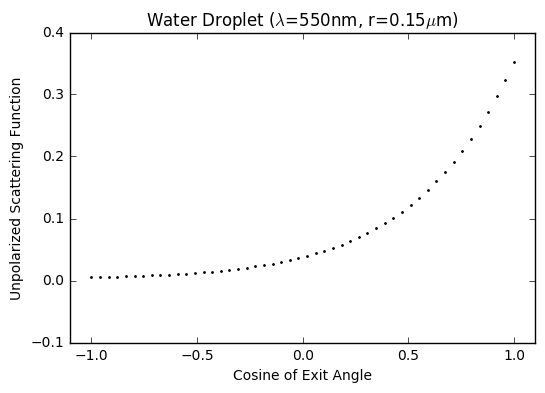

In [26]:
lambdaa = 0.550  # microns
m = 1.33         # water
r = 0.15        # microns

x = 2*np.pi*r/lambdaa

num=50
mu = np.linspace(-1,1,num)
s1, s2 = mp.mie_S1_S2(m,x,mu)
scat = (abs(s1)**2 + abs(s2)**2)/2

plt.scatter(mu, scat,s=1)
plt.xlabel('Cosine of Exit Angle')
plt.ylabel('Unpolarized Scattering Function')
plt.title(r'Water Droplet ($\lambda$=550nm, r=%.2f$\mu$m)'%r)
plt.ylim([-0.1,0.4])
plt.xlim([-1.1,1.1])

plt.show()

### The CDF

miepython has a function to generate the CDF directly

In [11]:
help(mp.mie_cdf)

Help on function mie_cdf in module miepython.miepython:

mie_cdf(m, x, num)
    Calculate the cumulative distribution function for unpolarized scattering
    for exit angles ranging from 180 to 0 degrees.  The cosines are uniformly
    distributed over -1 to 1.  Since this is a cumulative distribution
    function, the maximum value should be 1.
    
    Returns the mu and cdf



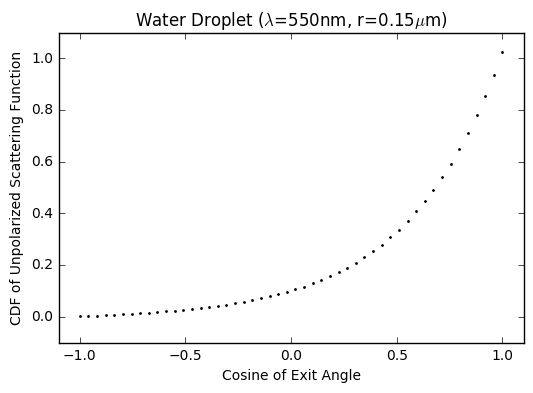

In [27]:
lambdaa = 0.550  # microns
m = 1.33         # water
r = 0.15          # microns

x = 2*np.pi*r/lambdaa

num=50
mu, cdf = mp.mie_cdf(m,x,num)

plt.scatter(mu,cdf,s=1)
plt.xlabel('Cosine of Exit Angle')
plt.ylabel('CDF of Unpolarized Scattering Function')
plt.title(r'Water Droplet ($\lambda$=550nm, r=%.2f$\mu$m)'%r)
plt.ylim([-0.1,1.1])
plt.xlim([-1.1,1.1])

plt.show()

### Inverting

To solve, we just reverse the $x$ and $y$ axes.

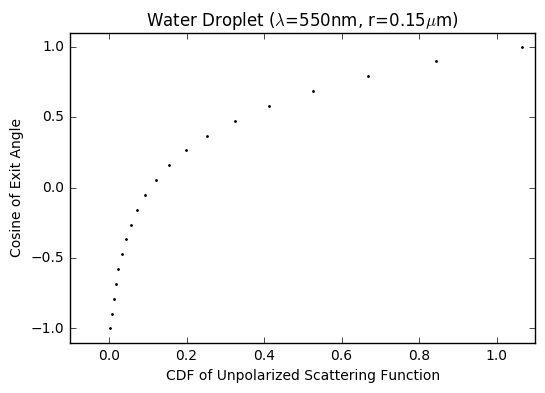

In [28]:
lambdaa = 0.550  # microns
m = 1.33         # water
r = 0.15          # microns

x = 2*np.pi*r/lambdaa

num=20
mu, cdf = mp.mie_cdf(m,x,num)

plt.scatter(cdf, mu, s=1)
plt.ylabel('Cosine of Exit Angle')
plt.xlabel('CDF of Unpolarized Scattering Function')
plt.title(r'Water Droplet ($\lambda$=550nm, r=%.2f$\mu$m)'%r)
plt.xlim([-0.1,1.1])
plt.ylim([-1.1,1.1])

plt.show()

### Better Inversion

In the graph above, the horizontal spacing is not uniform.  For speed in the Monte Carlo program we would like direct look ups into the array.  

Fortunately there is another function that returns a CDF with uniform spacing in CDF

In [4]:
help(mp.mie_mu_with_uniform_cdf)

Help on function mie_mu_at_delta_cdf in module miepython.miepython:

mie_mu_at_delta_cdf(m, x, num)
    Find the angles mu that correspond to uniform intervals on the cumulative
    distribution function for unpolarized Mie scattering.
    
    This is a brute force implementation that solves the problem by
    calculating the CDF at many points and then scanning to find the
    specific angles that correspond to uniform interval of the CDF.
    
    Returns mu and cdf with points uniformly spaced across the cdf, e.g.,
    cdf[i] = i/(num-1)  and mu[i] corresponds to this cdf value



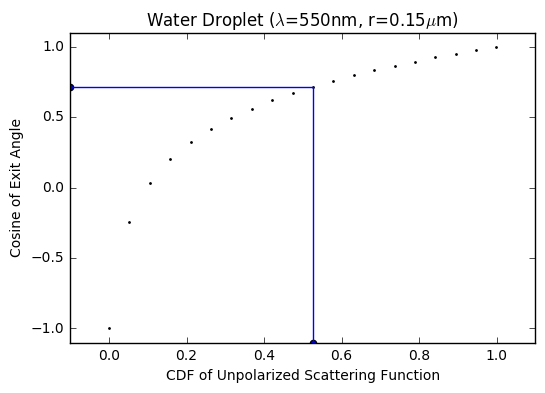

In [46]:
lambdaa = 0.550  # microns
m = 1.33         # water
r = 0.15         # microns

x = 2*np.pi*r/lambdaa

num=20
mid = num // 2
mu, cdf = mp.mie_mu_with_uniform_cdf(m,x,num)

plt.scatter(cdf, mu, s=1)
plt.plot([cdf[mid],cdf[mid]],[-1.1,mu[mid]],color='blue')
plt.plot([-0.1,cdf[mid]],[mu[mid],mu[mid]],color='blue')
plt.scatter([cdf[mid],-0.1],[-1.1,mu[mid]],s=20)

plt.ylabel('Cosine of Exit Angle')
plt.xlabel('CDF of Unpolarized Scattering Function')
plt.title(r'Water Droplet ($\lambda$=550nm, r=%.2f$\mu$m)'%r)
plt.xlim([-0.1,1.1])
plt.ylim([-1.1,1.1])

plt.show()
#print(cdf[mid],mu[mid])

And now the a random deviate along (say 0.526) will be mapped to the proper exit angle (0.715)

# Generating random Mie scattering angles

So now once we have calculated the magic mu array that has a CDF that is uniformly spaced, we can just do a quick look up to get the next random deviate.

In [73]:
help(mp.generate_mie_costheta)

Help on function generate_mie_costheta in module miepython.miepython:

generate_mie_costheta(mu_cdf)
    Generate a new scattering angle from a uniformly spaced cumulative
    distribution function (CDF). This is done by selecting a random interval
    mu[i] to mu[i+1] and then return an angle uniformly distributed over
    the interval.
    
    returns the cosine of the scattering angle



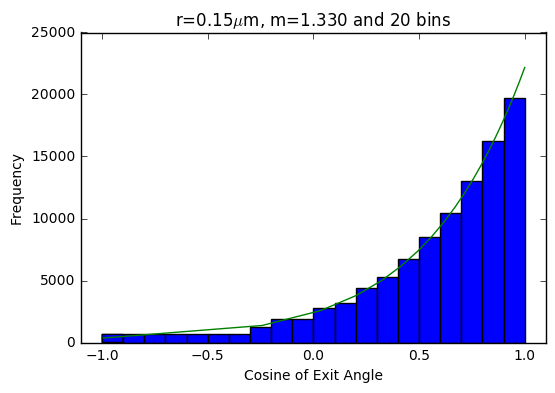

In [72]:
lambdaa = 0.550  # microns
m = 1.33         # water
r = 0.15         # microns
x = 2*np.pi*r/lambdaa

num_angles=20
mu, cdf = mp.mie_mu_with_uniform_cdf(m,x,num_angles)

# calculate the phase function at each angle
s1,s2 = mp.mie_S1_S2(m,x,mu)
s = (abs(s1)**2+abs(s2)**2)/2

# generate a bunch of random angles
num_deviates = 100000
angles = np.empty(num_deviates)
for i in range(num_deviates) :
    angles[i] = mp.generate_mie_costheta(mu)
    
num_bins = 20
plt.hist(angles, bins=num_bins)  
plt.plot(mu,s*num_deviates/num_bins*4*np.pi)

#plt.yscale('log')
plt.title("r=%.2f$\mu$m, m=%.3f and %d bins"%(r,m.real,num_bins))

plt.xlabel('Cosine of Exit Angle')
plt.ylabel('Frequency')
plt.xlim([-1.1,1.1])
plt.show()